# SIR models without the calculus

**Benjamin Vincent, University of Dundee, [@inferenceLab](https://twitter.com/inferencelab)**

_Note:_ this notebook is for educational purposes only. Model parameters were pretty much chosen at random, no effort to fit the parameters to data was made, so this is not meant to be a serious prediction of the current Covid-19 sitation. 

This notebook explores the SIRD (susceptible, infected, recovered, deceased) model. So far I am just implimenting the forward model to simulate and predict for known parameters. There is no inferential fitting to data.

## Features of the model:
- We model discrete number of people at discrete time points (days). This means we can avoid calculus and so the code becomes really very obvious and transparent.
- This simulation models a population the size of the UK at 66.44 million people.

## Model parameters
- $\alpha$ = infection rate
- $\beta$ = probability of recovering _per day_ if you are infected
- $\gamma$ = probability of dying _per day_ if you are infected

Interpretation of parameters:
- $\alpha$ is the infection rate - higher values mean that the disease spreads more rapidly and you get a steeper line on the semilog plots.
- $\beta$ can be seen as a scaling constant that modulates the time course of the disease.
- $\gamma / \beta$ is the _case fatality rate_, that is, the proportion of people who die versus recover.

The schematic below shows the basic idea of the discrete/discrete approach:
![Schematic of SIR model as Markov Chain](schematic.png)

In [1]:
using Distributions
using Plots

## Simulation code

In [2]:
function simulate(parameters; N=66_440_000,i₀=100, maxT=1000)
    α, β, γ = parameters
    # define initial conditions
    s, i, r, d =([N-i₀], [i₀], [0], [0])
    for t in [2:maxT;]
        # transitions
        si = rand(Binomial(s[end], (α * i[end]) / N[end]))
        ir = rand(Binomial(i[end], β))
        id = rand(Binomial(i[end], γ))
        # update counts
        push!(s, s[end] - si)
        push!(i, i[end] + si - ir - id)
        push!(r, r[end] + ir)
        push!(d, d[end] + id)
    end
    return (s, i, r, d)
end

simulate (generic function with 1 method)

## Plot code

In [3]:
icuCapacity = 4562

4562

In [4]:
function time_plot()
    p = plot(s/10^6, label="susceptible", lw=3, linecolour=:blue)
    plot!(i/10^6, label="infected", lw=3, linecolour=:red)
    plot!(r/10^6, label="recovered", lw=3, linecolour=:green)
    plot!(d/10^6, label="deceased", lw=3, linecolour=:black)
    N = s+i+r
    plot!(N/10^6, label="total population", lw=3, linecolour=:black, linestyle=:dash)
    hline!([icuCapacity/10^6], label="UK ICU beds", linecolour=:blue)
    
    xlabel!("time [days]")
    ylabel!("frequency (millions)")
    plot!(tickdir=:out)
    return p
end

time_plot (generic function with 1 method)

In [5]:
function semilog_plot()
    # mortality time plot
    t = [1:length(d);]
    inc = d.>0
    p = plot(t[inc], d[inc], yaxis=:log, label="deceased", lw=3, linecolour=:black)
    
    # infected time plot
    inc = i.>0
    plot!(t[inc], i[inc], label="infected", lw=3, linecolour=:red)
    hline!([icuCapacity], label="UK ICU beds", linecolour=:blue)
    
    xlabel!("time [days]")
    ylabel!("frequency")
    plot!(tickdir=:out)
    return p
end

semilog_plot (generic function with 1 method)

In [6]:
function per_day_plot()
    # deaths per day
    deaths_per_day = d[2:end] - d[1:end-1]
    p = plot([2:maxT], deaths_per_day / 10^6, label="deaths per day", lw=3, linecolour=:black)
    
    # new cases per day
    cases_per_day = s[1:end-1] - s[2:end]
    plot!([2:maxT], cases_per_day / 10^6, label="new cases per day", lw=3, linecolour=:red)
    
    xlabel!("time [days]")
    ylabel!("frequency (millions)")
    plot!(tickdir=:out)
    return p
end

per_day_plot (generic function with 1 method)

## Run a simulation

In [7]:
maxT = 365
parameters = (0.5, 0.05, 0.002)

s, i, r, d = simulate(parameters, i₀=100, maxT=maxT)

α, β, γ = parameters
print("Case fatality rate (γ/β) = $((γ/β)*100) %")

Case fatality rate (γ/β) = 4.0 %

## Plot prediction
Note that the forward model is stochastic, so slightly different results will happen on each run.

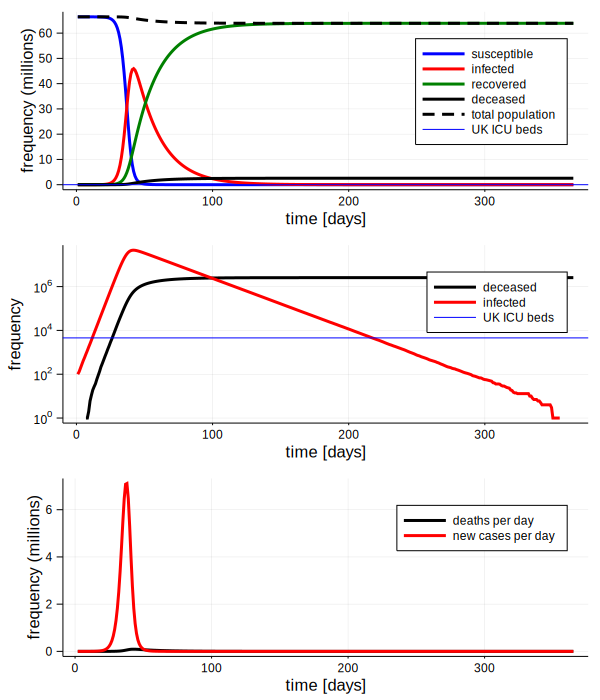

In [8]:
l = @layout [a ; b; c]
p1 = time_plot()
p2 = semilog_plot()
p3 = per_day_plot()
plot(p1, p2, p3, layout = l, size = (600, 700))

## Distribution of time spent infected
This is determined by the negative binomial distribution... number of days remaining infected until an infected -> recovered transition occurs. This occurs at a rate of $\beta$ per day.

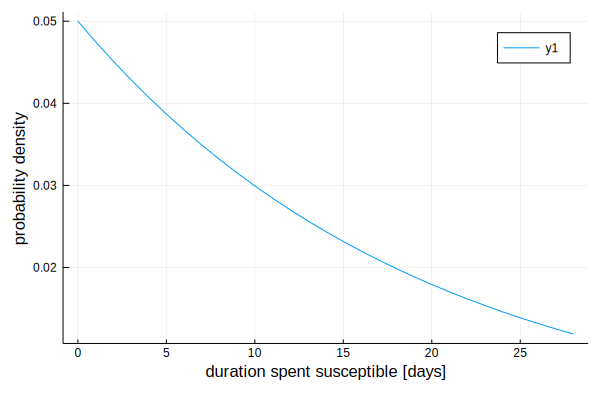

In [9]:
duration = [0:28;]
prob = pdf.(NegativeBinomial(1, β), duration)

plot(duration, prob)
xlabel!("duration spent susceptible [days]")
ylabel!("probability density")

# Further reading

- This work was inspired by a tweet by Chat Scherrer (https://twitter.com/ChadScherrer/status/1244289555403911168) who's doing some really nice work on probabilistic programming. The tweet pointed out that you need not evaluate SIR models using calculus. Instead, you can use discreete time and discrete counts and evaluate SIR models as a simple Markov chain.

- The following pre-print by Davies et al. https://cmmid.github.io/topics/covid19/control-measures/report/uk_scenario_modelling_preprint_2020_04_01.pdf